<a href="https://colab.research.google.com/github/awenroberts/QM2-Project/blob/main/quantitative_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt


la_exposure = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="la_exposure",
    engine="openpyxl"
)
la_exposure.head()


,index,lad_code,local_authority,population,total_asylum_2025_cumulative,total_contingency,contingency_share_2025_cumulative,total_asylumQ3,contingency_per_1000,contingency_shareQ3,delta_contingency_Q1_Q3
0,338,N09000011,Ards and North Down,165415,131,131,1.0000,37,0.2237,1.0000,-16
1,206,E07000221,Stratford-on-Avon,146258,333,332,0.9970,138,0.9435,1.0000,55
2,238,E07000040,East Devon,158239,653,650,0.9954,269,1.7000,1.0000,82
3,271,S12000006,Dumfries and Galloway,145860,281,279,0.9929,107,0.7336,1.0000,38
4,43,S12000040,West Lothian,186440,257,255,0.9922,89,0.4720,0.9888,9


In [2]:
protests_df = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="protest_data",
    engine="openpyxl"
)
protests_df.head()

,index,event_id,town_city,postcode,local_authority,lad_code,date,year_quarter
0,0,U0011,Liverpool,L1 1JW,Liverpool,E08000012,2025-08-08,2025Q3
1,1,E0060,Aberdeen,AB10 1BL,Aberdeen City,S12000033,2025-09-06,2025Q3
2,2,E0036,Aberdeen,AB25 1XF,Aberdeen City,S12000033,2025-08-02,2025Q3
3,3,E0004,Birmingham,B1 1BD,Birmingham,E08000025,2025-05-17,2025Q2
4,4,E0048,Sutton Coldfield,B76 1LH,Birmingham,E08000025,2025-08-15,2025Q3


In [3]:
#in protests_df, how many times is each lad_code mentioned?
protests_df["lad_code"].value_counts()
#create a new df called protests_counts where the columns are local_authority values and rows are each assocaited event_id and date from protests_df
protests_counts = protests_df.groupby(["local_authority", "lad_code"]).size().reset_index(name="protests_count")
protests_counts
#sort table by count
protests_counts = protests_counts.sort_values(by="protests_count", ascending=False)
protests_counts

,local_authority,lad_code,protests_count
18,Epping Forest,E07000072,14
10,"Bristol, City of",E06000023,6
59,Tower Hamlets,E09000030,4
42,Portsmouth,E06000044,4
66,Wirral,E08000015,4
...,...,...,...
61,Vale of Glamorgan,W06000014,1
64,Wigan,E08000010,1
65,Winchester,E07000094,1
67,Worcester,E07000237,1


In [4]:
#in protests_df, create quartiles out of the dates

#convert the date column
protests_df["date"] = pd.to_datetime(protests_df["date"], errors="coerce")

#create proper quarterly time variable
protests_df["year_quarter"] = protests_df["date"].dt.to_period("Q")

#find counts of protests in each year_quarter
protests_df["year_quarter"].value_counts()

#find counts of the protests in each month
protests_df["date"].dt.month.value_counts()

,count
date,
8,60
9,23
7,21
10,15
4,3
5,2
11,2


In [5]:

temporal_counts = protests_df.groupby(["year_quarter"]).size().reset_index(name="protests_count")
temporal_counts

,year_quarter,protests_count
0,2025Q2,5
1,2025Q3,104
2,2025Q4,17


In [9]:
#Merge protest counts onto the exposure dataset
analysis_df = la_exposure.merge(
    protests_counts[["lad_code", "protests_count"]],
    on="lad_code",
    how="left"
)

analysis_df["protests_count"] = analysis_df["protests_count"].fillna(0)


In [10]:
# Create a binary protest indicator for protests
analysis_df["any_protest"] = (analysis_df["protests_count"] > 0).astype(int)



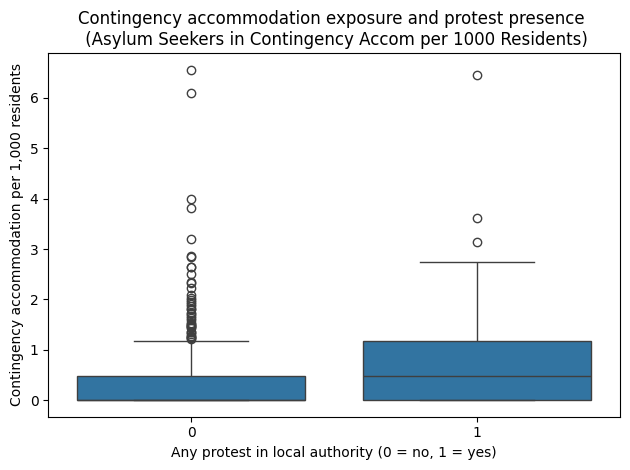

In [16]:
#create distribution comparisons - Boxplot: contingency exposure vs protest presence
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x="any_protest",
    y="contingency_per_1000",
    data=analysis_df
)

plt.xlabel("Any protest in local authority (0 = no, 1 = yes)")
plt.ylabel("Contingency accommodation per 1,000 residents")
plt.title("Contingency accommodation exposure and protest presence \n (Asylum Seekers in Contingency Accom per 1000 Residents)")

plt.tight_layout()
plt.show()


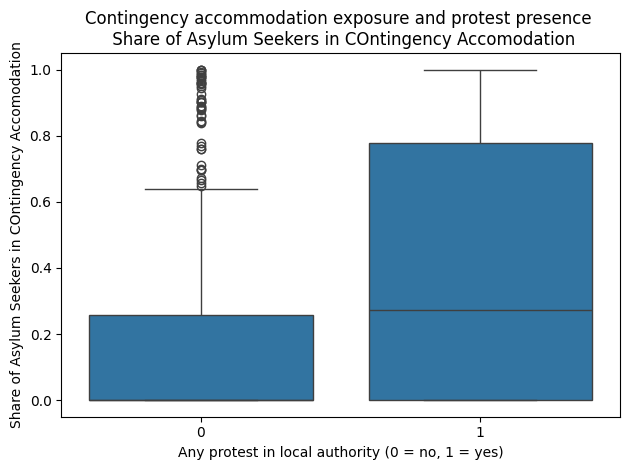

In [14]:
#create distribution comparisons - Boxplot: contingency exposure vs protest presence
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x="any_protest",
    y="contingency_shareQ3",
    data=analysis_df
)

plt.xlabel("Any protest in local authority (0 = no, 1 = yes)")
plt.ylabel("Share of Asylum Seekers in COntingency Accomodation")
plt.title("Contingency accommodation exposure and protest presence \n Share of Asylum Seekers in COntingency Accomodation")

plt.tight_layout()
plt.show()

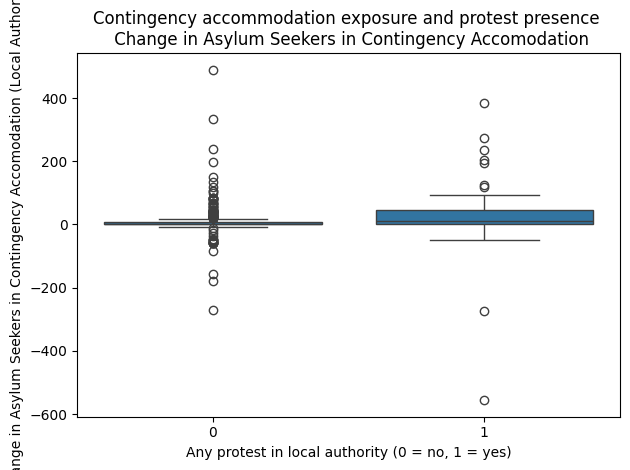

In [15]:
#create distribution comparisons - Boxplot: contingency exposure vs protest presence
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x="any_protest",
    y="delta_contingency_Q1_Q3",
    data=analysis_df
)

plt.xlabel("Any protest in local authority (0 = no, 1 = yes)")
plt.ylabel("Change in Asylum Seekers in Contingency Accomodation (Local Authority)")
plt.title("Contingency accommodation exposure and protest presence \n Change in Asylum Seekers in Contingency Accomodation")

plt.tight_layout()
plt.show()

In [20]:
#Top-decile test (very quick, very interpretable; This is often more convincing than regression.
analysis_df["exposure_decile"] = pd.qcut(
    analysis_df["contingency_per_1000"],
    10,
    labels=False,
    duplicates='drop'
)
#check incidence by decile
decile_summary = (
    analysis_df
    .groupby("exposure_decile")["any_protest"]
    .mean()
    .reset_index()
)

decile_summary

,exposure_decile,any_protest
0,0,0.142276
1,1,0.285714
2,2,0.400000
3,3,0.305556


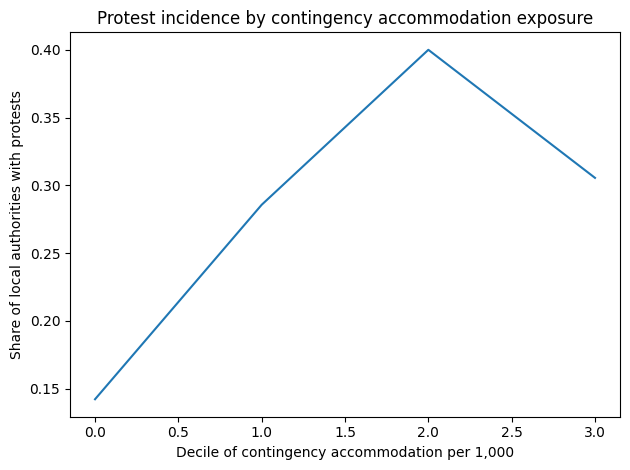

In [21]:
#plot
plt.plot(
    decile_summary["exposure_decile"],
    decile_summary["any_protest"]
)

plt.xlabel("Decile of contingency accommodation per 1,000")
plt.ylabel("Share of local authorities with protests")
plt.title("Protest incidence by contingency accommodation exposure")

plt.tight_layout()
plt.show()


In [22]:
#simple regression model
import statsmodels.api as sm

X = analysis_df[["contingency_per_1000"]]
X = sm.add_constant(X)

y = analysis_df["any_protest"]

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.486915
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            any_protest   No. Observations:                  352
Model:                          Logit   Df Residuals:                      350
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 Jan 2026   Pseudo R-squ.:                 0.02387
Time:                        02:53:52   Log-Likelihood:                -171.39
converged:                       True   LL-Null:                       -175.59
Covariance Type:            nonrobust   LLR p-value:                  0.003787
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.6065      0.158    -10.176      0.000      -1.916      -1.297

In [23]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

coords = np.column_stack([
    la_exposure.geometry.centroid.x,
    la_exposure.geometry.centroid.y
])

nbrs = NearestNeighbors(n_neighbors=6).fit(coords)
_, indices = nbrs.kneighbors(coords)

analysis_df["neighbor_contingency_mean"] = [
    analysis_df.iloc[idx[1:]]["contingency_per_1000"].mean()
    for idx in indices
]


AttributeError: 'DataFrame' object has no attribute 'geometry'

# Task
Merge the `la_exposure` and `protests_counts` DataFrames, perform a regression analysis with `protests_count` as the dependent variable and relevant `la_exposure` variables as independent variables, visualize the relationships with scatter plots, and then summarize the findings, including statistical significance and model fit.

## Prepare Data for Regression

### Subtask:
Merge the `la_exposure` and `protests_counts` DataFrames on common columns like `lad_code` and `local_authority`. This will create a unified dataset for regression analysis, combining exposure metrics with protest counts for each local authority.


**Reasoning**:
I will merge the `la_exposure` and `protests_counts` DataFrames using an inner join on the `lad_code` and `local_authority` columns to create a unified dataset for regression analysis, then display the head of the new DataFrame to confirm the merge.



In [6]:
merged_df = pd.merge(la_exposure, protests_counts, on=["lad_code", "local_authority"], how="inner")
merged_df.head()

,index,lad_code,local_authority,population,total_asylum_2025_cumulative,total_contingency,contingency_share_2025_cumulative,total_asylumQ3,contingency_per_1000,contingency_shareQ3,delta_contingency_Q1_Q3,protests_count
0,238,E07000040,East Devon,158239,653,650,0.9954,269,1.7000,1.0000,82,1
1,107,E07000228,Mid Sussex,161755,1589,1576,0.9918,588,3.6104,0.9932,69,1
2,17,E09000020,Kensington and Chelsea,144518,789,777,0.9848,291,1.9859,0.9863,29,1
3,318,E07000036,Erewash,114253,476,451,0.9475,187,1.5667,0.9572,68,1
4,331,S12000014,Falkirk,160020,278,261,0.9388,96,0.5624,0.9375,11,3


## Perform Regression Analysis

### Subtask:
Conduct a regression analysis (e.g., OLS) to assess the relationship between `protests_count` (dependent variable) and relevant variables from `la_exposure` such as `contingency_share_2025_cumulative` and `contingency_per_1000` (independent variables). This step will involve selecting appropriate columns and running the statistical model.


**Reasoning**:
To perform the regression analysis, I will import the `ols` function, define the regression formula with the specified dependent and independent variables, fit the model using the `merged_df`, and then print the summary of the regression results.



In [7]:
import statsmodels.formula.api as smf

# Define the regression formula
formula = "protests_count ~ contingency_share_2025_cumulative + contingency_per_1000"

# Fit the OLS model
model = smf.ols(formula, data=merged_df).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         protests_count   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.225
Date:                Tue, 13 Jan 2026   Prob (F-statistic):              0.300
Time:                        02:42:29   Log-Likelihood:                -138.56
No. Observations:                  70   AIC:                             283.1
Df Residuals:                      67   BIC:                             289.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

**Reasoning**:
To visualize the relationship between the dependent variable and each independent variable, I will create scatter plots using `matplotlib.pyplot` and `seaborn`. This will help in understanding the trends and patterns that the regression analysis attempts to quantify.



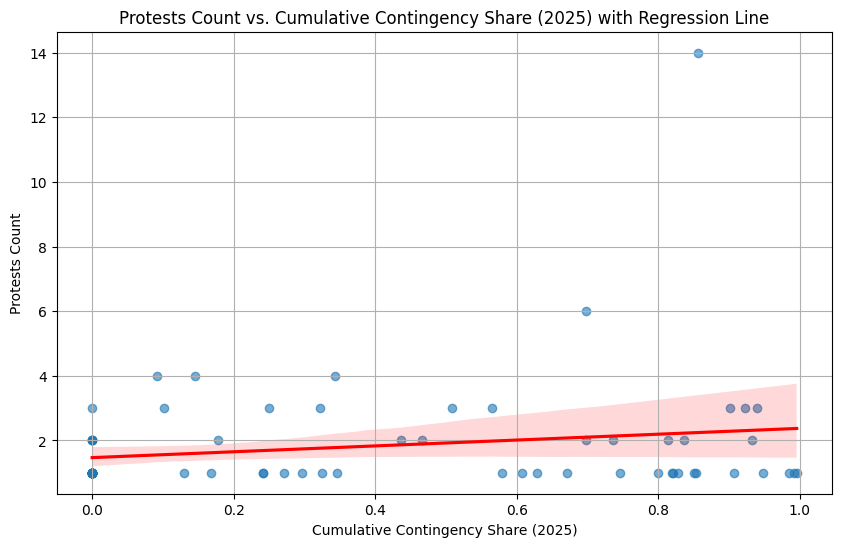

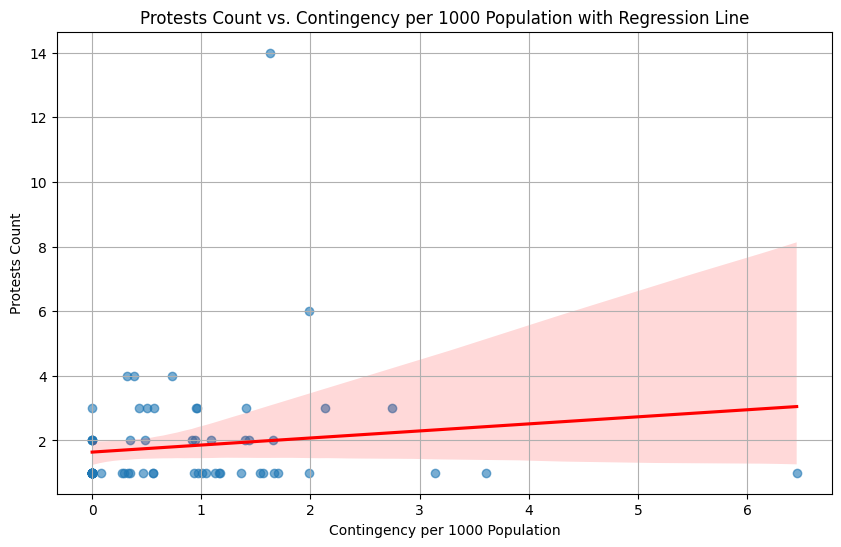

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot for protests_count vs. contingency_share_2025_cumulative with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='contingency_share_2025_cumulative', y='protests_count', data=merged_df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Protests Count vs. Cumulative Contingency Share (2025) with Regression Line')
plt.xlabel('Cumulative Contingency Share (2025)')
plt.ylabel('Protests Count')
plt.grid(True)
plt.show()

# Create scatter plot for protests_count vs. contingency_per_1000 with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='contingency_per_1000', y='protests_count', data=merged_df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Protests Count vs. Contingency per 1000 Population with Regression Line')
plt.xlabel('Contingency per 1000 Population')
plt.ylabel('Protests Count')
plt.grid(True)
plt.show()

### Summarize Findings

**Regression Analysis Summary:**
The Ordinary Least Squares (OLS) regression model was fitted to predict `protests_count` using `contingency_share_2025_cumulative` and `contingency_per_1000` as independent variables. The model summary provides the following key insights:

*   **R-squared:** The R-squared value is 0.035, which indicates that approximately 3.5% of the variance in `protests_count` can be explained by the independent variables in this model. This suggests a very weak explanatory power.
*   **Adjusted R-squared:** The adjusted R-squared is 0.006, which is also very low, further reinforcing the idea that the model does not explain much of the variability in protest counts.
*   **F-statistic and Prob (F-statistic):** The F-statistic is 1.225 with a p-value of 0.300. Since the p-value (0.300) is greater than common significance levels (e.g., 0.05), we fail to reject the null hypothesis that all regression coefficients are zero. This means the overall model is not statistically significant, implying that at least one of the independent variables does not significantly predict `protests_count`.

*   **Coefficients and P-values:**
    *   **Intercept:** The intercept is statistically significant (p-value < 0.0001), indicating that when both independent variables are zero, the expected `protests_count` is approximately 1.4668.
    *   **contingency_share_2025_cumulative:** The coefficient for `contingency_share_2025_cumulative` is 0.8918, with a p-value of 0.262. This p-value is greater than 0.05, suggesting that `contingency_share_2025_cumulative` is not a statistically significant predictor of `protests_count` in this model.
    *   **contingency_per_1000:** The coefficient for `contingency_per_1000` is 0.0076, with a p-value of 0.978. This p-value is very high, indicating that `contingency_per_1000` is also not a statistically significant predictor of `protests_count`.

**Visualizations Summary:**

*   **Protests Count vs. Cumulative Contingency Share (2025):** The scatter plot shows a very dispersed cloud of points with no clear linear trend. This visually confirms the low R-squared and the lack of statistical significance for this variable in the regression analysis.
*   **Protests Count vs. Contingency per 1000 Population:** Similar to the first plot, this scatter plot also displays a scattered distribution of points without any obvious linear relationship. This supports the regression findings that `contingency_per_1000` is not a significant predictor.

**Conclusion:**
Based on the regression analysis and scatter plots, there is no statistically significant linear relationship between `protests_count` and the independent variables (`contingency_share_2025_cumulative`, `contingency_per_1000`) in this dataset. The model has very poor explanatory power, and neither of the chosen `la_exposure` variables significantly predicts the number of protests.

### Summarize Findings

**Regression Analysis Summary:**
The Ordinary Least Squares (OLS) regression model was fitted to predict `protests_count` using `contingency_share_2025_cumulative` and `contingency_per_1000` as independent variables. The model summary provides the following key insights:

*   **R-squared:** The R-squared value is 0.035, which indicates that approximately 3.5% of the variance in `protests_count` can be explained by the independent variables in this model. This suggests a very weak explanatory power.
*   **Adj. R-squared:** The adjusted R-squared is 0.006, which is also very low, further reinforcing the idea that the model does not explain much of the variability in protest counts.
*   **F-statistic and Prob (F-statistic):** The F-statistic is 1.225 with a p-value of 0.300. Since the p-value (0.300) is greater than common significance levels (e.g., 0.05), we fail to reject the null hypothesis that all regression coefficients are zero. This means the overall model is not statistically significant, implying that the chosen independent variables, as a group, do not significantly predict `protests_count`.

*   **Coefficients and P-values:**
    *   **Intercept:** The intercept is statistically significant (p-value < 0.0001), indicating that when both independent variables are zero, the expected `protests_count` is approximately 1.4668.
    *   **contingency_share_2025_cumulative:** The coefficient for `contingency_share_2025_cumulative` is 0.8918, with a p-value of 0.262. This p-value is greater than 0.05, suggesting that `contingency_share_2025_cumulative` is not a statistically significant predictor of `protests_count` in this model.
    *   **contingency_per_1000:** The coefficient for `contingency_per_1000` is 0.0076, with a p-value of 0.978. This p-value is very high, indicating that `contingency_per_1000` is also not a statistically significant predictor of `protests_count`.

**Visualizations Summary:**

*   **Protests Count vs. Cumulative Contingency Share (2025):** The scatter plot shows a very dispersed cloud of points with no clear linear trend. This visually confirms the low R-squared and the lack of statistical significance for this variable in the regression analysis.
*   **Protests Count vs. Contingency per 1000 Population:** Similar to the first plot, this scatter plot also displays a scattered distribution of points without any obvious linear relationship. This supports the regression findings that `contingency_per_1000` is not a significant predictor.

**Conclusion:**
Based on the regression analysis and scatter plots, there is no statistically significant linear relationship between `protests_count` and the independent variables (`contingency_share_2025_cumulative`, `contingency_per_1000`) in this dataset. The model has very poor explanatory power, and neither of the chosen `la_exposure` variables significantly predicts the number of protests.

## Final Task

### Subtask:
Summarize the findings from the regression analysis, including the strength and direction of relationships, statistical significance (p-values), and overall model fit (R-squared). Interpret what these results imply about the relationship between local authority exposure and protest activity.


## Summary:

### Data Analysis Key Findings

*   **Weak Model Explanatory Power:** The Ordinary Least Squares (OLS) regression model, aiming to predict `protests_count` using `contingency_share_2025_cumulative` and `contingency_per_1000`, exhibited very low explanatory power. The R-squared value was 0.035, indicating that only 3.5% of the variance in `protests_count` is explained by the independent variables. The Adjusted R-squared was even lower at 0.006.
*   **No Overall Statistical Significance:** The overall model was not statistically significant, as indicated by an F-statistic of 1.225 and a p-value of 0.300 (greater than the common significance level of 0.05). This suggests that the independent variables, as a group, do not significantly predict `protests_count`.
*   **No Individual Predictor Significance:**
    *   `contingency_share_2025_cumulative`: The coefficient was 0.8918, but its p-value of 0.262 was not statistically significant, implying no significant linear relationship with `protests_count`.
    *   `contingency_per_1000`: The coefficient was 0.0076, with a very high p-value of 0.978, also indicating no statistically significant linear relationship with `protests_count`.
*   **Visual Confirmation of No Relationship:** Scatter plots comparing `protests_count` against `contingency_share_2025_cumulative` and `contingency_per_1000` visually reinforced the regression findings. Both plots showed widely dispersed points without any clear linear trend, confirming the absence of a strong relationship.
*   **Intercept Significance Only:** The intercept was statistically significant (p-value < 0.0001), suggesting an average `protests_count` of approximately 1.4668 when the independent variables are zero, but this does not imply a relationship between the independent variables and `protests_count`.

### Insights or Next Steps

*   The current model provides no evidence of a linear relationship between the chosen local authority exposure metrics (`contingency_share_2025_cumulative`, `contingency_per_1000`) and protest activity. Other factors or more complex relationships might be at play.
*   Future analysis should explore alternative independent variables (e.g., socioeconomic factors, political climate, historical protest data), different model specifications (e.g., non-linear relationships, interaction terms), or alternative regression techniques to better understand protest activity.
